<a href="https://colab.research.google.com/github/comandi1969/AIFFEL_Online_Quest/blob/main/DL_Master/%EB%B0%91%EC%8B%9C%EB%94%A5__7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

In [3]:
# simple_convnet.py
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망

    conv - relu - pool - affine - relu - affine - softmax

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]


Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
train loss:2.299164265574655
=== epoch:1, train acc:0.097, test acc:0.108 ===
train loss:2.297713748840736
train loss:2.29208491914448
train loss:2.2900162033294573
train loss:2.282172721567297
train loss:2.276190883202125
train loss:2.256179402979977
train loss:2.237156904840324
train loss:2.24242977557541
train loss:2.2073342941635867
train loss:2.163202204334097
train loss:2.141978323494877
train loss:2.0843026282310153
train loss:2.077733777731855
train loss:2.0655070765705275
train loss:1.9496852041843604
train loss:1.911019301353272
train loss:1.8627634921317233
train loss:1.7459304229835806
train loss:1.6741361176601068
train loss:1.6105182485286114
train loss:1.48449990551203
train loss:1.4953013697322484


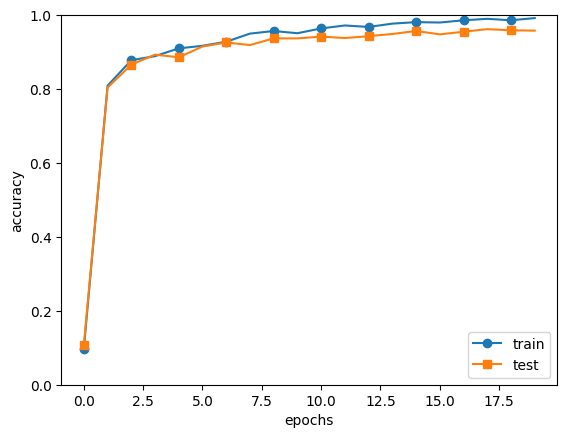

In [7]:
# coding: utf-8
import sys, os
# sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28),
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


[[ 961    0    2    0    0    3    8    3    3    0]
 [   0 1123    4    1    0    1    3    0    3    0]
 [   4    3  996   11    3    0    1    7    7    0]
 [   0    1    6  977    0   10    0    5    8    3]
 [   0    4    2    0  959    0   10    1    2    4]
 [   4    2    0    3    0  869    3    2    9    0]
 [   7    3    5    0   10   14  914    0    5    0]
 [   0    8   24    3    4    1    0  972    3   13]
 [   3    5    6   21    6   15    8    6  902    2]
 [   3   10    2   11   28   15    1   12   12  915]]
95.88


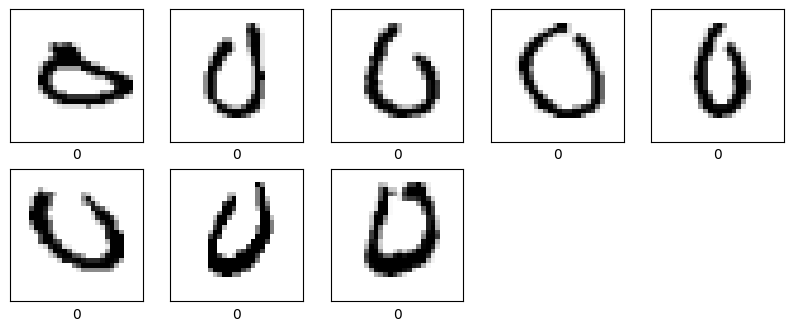

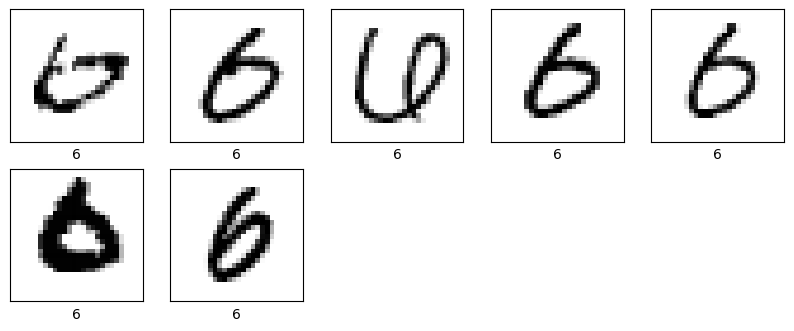

In [13]:
# cnn confusion matxi
# coding: utf-8
import sys, os
# sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
import pickle
from dataset.mnist import load_mnist
from common.simple_convnet import SimpleConvNet
np.set_printoptions(linewidth=150,threshold=1000)

def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=False, one_hot_label=False)
    return x_test, t_test

x, t = get_data()

network = SimpleConvNet()

# 학습된 가중치
network.load_params("params.pkl")

confusion = np.zeros((10,10), dtype=int)

for k in range(len(x)):
    i=int(t[k])
    y = network.predict(x[k].reshape(1,*x[k].shape))
    j= np.argmax(y) # 확률이 가장 높은 원소의 인덱스를 얻는다.
    confusion[i][j] += 1

print(confusion)

accuracy=0

for k in range(len(confusion)):
    accuracy+=confusion[k][k]

accuracy=accuracy/np.sum(confusion)*100
print(accuracy)

y = np.argmax(network.predict(x), axis=1)

number1=0
number2=6
number1_number2=[]
number2_number1=[]

for k in range(len(x)):
    i=int(t[k])
    y = network.predict(x[k].reshape(1,*x[k].shape))
    j= np.argmax(y) # 확률이 가장 높은 원소의 인덱스를 얻는다.
    if i==number1 and j==number2:
        number1_number2.append(k)
    if i==number2 and j==number1:
        number2_number1.append(k)

plt.figure(figsize=(10,10))
for i in range(len(number1_number2)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x[number1_number2[i]].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(t[number1_number2[i]])
plt.show()

plt.figure(figsize=(10,10))
for i in range(len(number2_number1)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x[number2_number1[i]].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(t[number2_number1[i]])
plt.show()